<a href="https://colab.research.google.com/github/gustavoteixeirah/ELT575-Aprendizado-Profundo/blob/main/Transfer_learning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

Uma das grande barreiras para o uso das redes convolucionais é o grande volume de dados que é necessário para treinar esse tipo de modelo profundo. No entanto, podemos contornar isso fazendo uso de redes pré-treinadas em grandes conjuntos de imagens, tentando assim aproveitar a generalização de características comuns mesmo para dados de contextos diferentes. Essa técnica é chamada de ***Transfer Learning***, não sendo exclusiva para redes convolucionais.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Importando dados

Usaremos dados provenientes de uma base de imagens de folhas de plantas com a presença de doenças. O dataset original e uma abordagem de transfer learning para ele pode ser encontrado em https://github.com/abhinavsagar/plant-disease. Aqui trabalharemos com um recorte desse dataset, analisando apenas folhas de árvores de maçã com a presença de algumas patologias.
* Ao trabalhar apenas com esse recorte, temos ainda menos dados, o que torna a tarefa de treinar um modelo profundo bem mais difícil.

* Esse recorte do dataset está disponível na plataforma do curso

In [ ]:
path = 'gdrive/MyDrive/Pos_Inteligencia_Computacional_UFV/TransferLearning'

A opção mais clássica para importar os dados é fazer o carregamento de todo o conteúdo diretamente para a memória RAM. Isso funciona bem para volumes de dados que possam ser contidos totalmente na memória da máquina, mas não é uma boa estratégia para altos volumes de dados (muito comuns quando lidando com Big Data)

* Usaremos então um recurso do tensorflow chamado ImageDataGenerator. Esse recurso cria um iterador que gera lotes (*batches*) de imagens a cada iteração, podendo estar apontando para um diretório onde estão nossas amostras (que são imagens nesse exemplo)

* Usaremos o método flow_from_directory para carregar esses dados. Esse método requer que os dados de cada classe estejam em pastas diferentes, sendo que teremos 4 pastas para nossas 4 classes.

* O ImageDataGenerator permite que já façamos algumas transformações nos dados, como fazer a divisão treino-teste e algumas transformações que podem ser aplicadas em imagens, como zoom ou deslocamentos laterais. Mais detalhes sobre essa ferramenta estão disponíveis em https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
# Tamanho das imagens para que sejam usadas como entradas da VGG16
img_size = (224,224)

batch_size = 32

img_gen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2,
                             #shear_range=0.2,
                             #zoom_range=0.2,
                             #horizontal_flip=True)
                             )

train_generator = img_gen.flow_from_directory(path + '/Apple_flowers',
                                              target_size=img_size,
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              subset='training')

test_generator = img_gen.flow_from_directory(path + '/Apple_flowers',
                                             target_size=img_size,
                                             class_mode = 'categorical',
                                             batch_size=batch_size,
                                             subset='validation')

Found 2537 images belonging to 4 classes.
Found 634 images belonging to 4 classes.


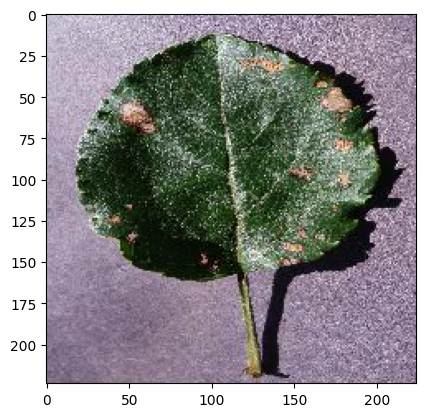

In [ ]:
# Exemplo de uma imagem do conjunto que estamos usando
batch_example = train_generator.next()
example = batch_example[0][2]

plt.imshow(example);

# Construção do Modelo

Aqui construíremos nosso modelo. Usaremos como base o modelo VGG16 pré-treinado com o conjunto de dados *ImageNet*

* A ideia do Transfer Learning é usar o modelo pré-treinado para extrair algumas características dos nossos dados. Essas extração de características foi previamente aprendida no *ImageNet*

* Para que o modelo seja treinado para o contexto dos nossos dados, excluímos as últimas camadas totalmente conectadas do VGG16, adicionando novas camadas para serem treinadas. Assim, podemos pensar que estamos apenas usando a rede pré-treinada para extrair características e treinando uma rede mlp nova com essas características.

* É importante que façamos com que os pesos dadas camadas extratoras da VGG16 não se alterem durante o treinamento. Apenas as camadas totalmente conectadas que adicionaremos ao modelo é que serão alteradas durante o treinamento

In [ ]:
# Carregamos o modelo VGG16 sem as últimas camadas totalmente conectadas (include_top=False)
pre_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Aqui fazemos com que as camadas do modelo pré-treinado não sejam alteradas durante o treino
for layer in pre_model.layers:
  layer.trainable = False

# Criamos então um modelo sequential onde temos o VGG16 seguido das novas camadas conectadas
model = Sequential()

model.add(pre_model)
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Checando a estrutura do modelo criado
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0

# Treinamento do modelo

Finalmente, treinaremos nosso modelo. Para isso podemos passar como dados os geradores que criamos a partir do *ImageDataGenerator*, sendo necessário apenas especificar o número de passos por época de treinamento (*steps_per_epoch*)

In [ ]:
model.fit(train_generator,
          epochs=30,
          steps_per_epoch=train_generator.samples // batch_size,
          validation_data=test_generator,
          verbose=1)

Epoch 1/30
79/79 [==============================] - 1285s 16s/step - loss: 1.1675 - accuracy: 0.4591 - val_loss: 0.6508 - val_accuracy: 0.7003
Epoch 2/30
79/79 [==============================] - 14s 172ms/step - loss: 0.6760 - accuracy: 0.6830 - val_loss: 0.3776 - val_accuracy: 0.8707
Epoch 3/30
79/79 [==============================] - 14s 172ms/step - loss: 0.4397 - accuracy: 0.8068 - val_loss: 0.1411 - val_accuracy: 0.9590
Epoch 4/30
79/79 [==============================] - 14s 173ms/step - loss: 0.2688 - accuracy: 0.9026 - val_loss: 0.1211 - val_accuracy: 0.9606
Epoch 5/30
79/79 [==============================] - 14s 174ms/step - loss: 0.2017 - accuracy: 0.9357 - val_loss: 0.1132 - val_accuracy: 0.9558
Epoch 6/30
79/79 [==============================] - 14s 175ms/step - loss: 0.1500 - accuracy: 0.9457 - val_loss: 0.1034 - val_accuracy: 0.9685
Epoch 7/30
79/79 [==============================] - 14s 176ms/step - loss: 0.1577 - accuracy: 0.9453 - val_loss: 0.0938 - val_accuracy: 0.9716

# Testando Modelo

A acurácia obtida foi de 97,32%, que parece ser um valor razoável para esse problema. Podemos também avaliar outras medidas, como Precisão, Recall e F1-Score, caso seja preciso um maior detalhamento do desempenho do modelo em cada classe.

Exemplo de imagem do conjunto de teste


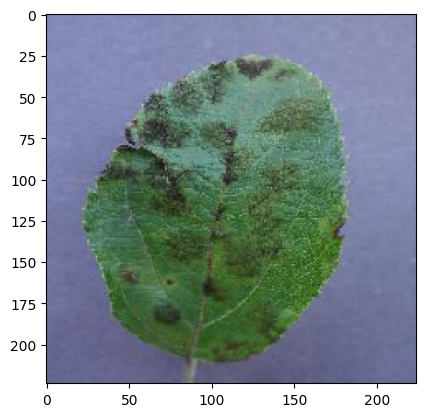

In [ ]:
# Lote de 32 imagens do conjunto de teste para classificação
batch_example = test_generator.next()
example = batch_example[0][0]

print('Exemplo de imagem do conjunto de teste')
plt.imshow(example);

Faremos agora a classificação do lote de imagens com nosso modelo e identificaremos as classes previstas

In [ ]:
np.argmax(model.predict(batch_example[0]), axis=1)

1/1 [==============================] - 0s 220ms/step


array([0, 0, 0, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 0,
       3, 1, 3, 3, 2, 1, 0, 1, 1, 3])

Agora comparamos com as classes reais dessas imagens do conjunto de teste

In [ ]:
np.argmax(batch_example[1], axis=1)

array([0, 0, 0, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 0, 3, 0,
       3, 1, 3, 3, 2, 1, 0, 1, 1, 3])

Cada classe corresponde a uma das seguintes condições da folha presente na imagem

In [ ]:
test_generator.class_indices